# Homework 12

Section 10.1

Math 404

Winter 2020

Logan Schelly

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.base import TransformerMixin
from sklearn.datasets import load_iris, load_breast_cancer
from keras.datasets import fashion_mnist

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

## Exercise 10.1
Code up the PCA algorithm (you may use a built-in SVD solver).  Your code should...

### Part (i)
Accept a matrix $X$ where each row is a data point, and each column is a feature, and accept an optional integer $s$ number of principal components to compute.  If $s =$ ``None``, then assume $s=d$ (the number of features of the data).

### Part (ii)
Compute the variance $(\sigma_1^2, \ldots, \sigma_s^2)$ for the first $s$ principal directions.

In [2]:
class PCATransformer(TransformerMixin):
    
    def __init__(self, s=None):
        self.n_components = s
    
    def fit(self, X, y=None, s=None):
        #Part i
        N, d = X.shape
        if self.n_components==None:
            self.n_components = d
        #Part ii
        U, sigma, Vh = np.linalg.svd(X, full_matrices=False)
        self.principal_directions_ = Vh
        self.variances_ = sigma[:]**2

### Part (iii)
Provide a method ``.transform`` that accepts new data points $\mathbf{x} \in \mathbb{R}^d$ and returns the principal components
$(a_1, \ldots, a_s) = (\mathbf{v}_1^{\intercal}\mathbf{x}, \ldots, \mathbf{v}_s^{\intercal}\mathbf{x})$.

In [3]:
class PCATransformer(PCATransformer):
    
    def transform(self, X):
        """
        Parameters:
        -----------
        X - ndarray of shape (N,d) or (d,)
            If 2 axes, X[i,:] represents the ith data point.
        
        Returns:
        --------
        A - ndarray of shape (N,s)
            A[i, j] is the component of X[i] along the jth principal direction.
        """
        s = self.n_components
        return X.dot(self.principal_directions_[:s].T)

### Part (iv)
Provide a ``.project`` method that accepts data points $\mathbf{x} \in \mathbb{R}^d$ and returns the projection $\text{proj}_{\text{span}(\mathbf{v}_1, \ldots, \mathbf{v}_s)}\mathbf{x} = \sum_{i=1}^{s}a_i \mathbf{v}_i$ of $\mathbf{x}$ to the subspace spanned by the principal axes $(\mathbf{v}_1,\ldots, \mathbf{v}_s)$.

In [4]:
class PCATransformer(PCATransformer):
    
    def project(self, X):
        A = self.transform(X)
        s = self.n_components
        return A.dot(self.principal_directions_[:s])

## Exercise 10.2
Consider the following datasets:
* Iris 
* Wisconsin Breast Cancer 
* Fashion-MNIST

For each dataset do the following:

1. Remove id numbers and other irrelevant data.  Separate the data into $X$ (the features for each data point) and $y$ (a classification, diagnosis, or dependent variable).

2. Identify whether the data $X$ is suitable for PCA as is, or whether it needs centering, normalization, conversion of categorical data to continuous (as in MCA), or other adjustments.  Make the necessary transformations.

3. Using your code from the previous problem (or a standard implementation of PCA), find the variance for each principal axis and plot the amount of variance explained as a function of the number of principal components (cumulative variance explained) and the variance explained by each of the principal components (as a scree plot).  Is there a value of $s$ that is much less than $d$ but such that the first $s$ principal components still explain most of the variance?  Explain.

4. Compute the first two principal components of $X$.  Plot this as a scatterplot where the color of each point is determined by the corresponding label $y$.  Does this 2-variable PCA do a good job of separating the different classes?  Explain this in terms of the plots you made for the previous part of this problem.

### Iris part (i)

In [5]:
iris = load_iris()
X = iris.data.copy()
y = iris.target
#Id numbers are not included.  Only the 4 features are there.

### Iris part (ii)

The data will need both centering and normalization, as Example 10.1.2.(iv) explains.

In [6]:
X -= X.mean(axis=0)
X /= X.std(axis=0, ddof=1)

### Iris part (iii)

Variance for each principal axis: [434.85617466 136.19054025  21.86677446   3.08651063]


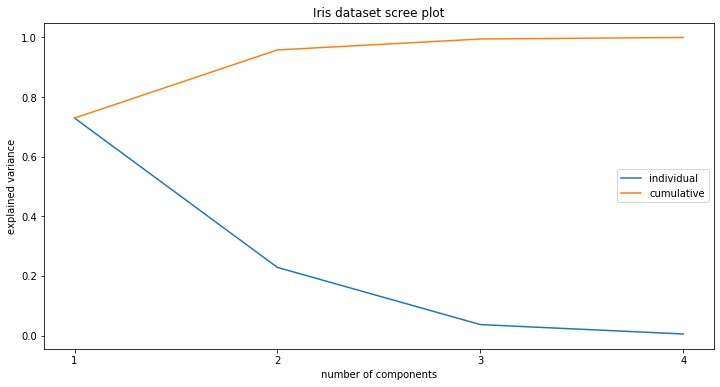

In [7]:
def part3(tfmr, X, max_variances_printed=50):
    
    #Variance for each principal axis
    tfmr.fit(X)
    if (tfmr.variances_.size > max_variances_printed):
        print("Variance for first 50 principal axes:", tfmr.variances_[:50])
    else:
        print("Variance for each principal axis:", tfmr.variances_)
    
    #Plotting
    fig = plt.figure(figsize=(12, 6))
    x = np.arange(tfmr.variances_.size) + 1
    tot_variance = tfmr.variances_.sum()
    plt.plot(x, tfmr.variances_/tot_variance, label="individual")
    plt.plot(x, tfmr.variances_.cumsum()/tot_variance, label="cumulative")
    plt.xlabel("number of components")
    if x.size < 50:
        plt.xticks(x)
    else:
        n = np.ceil(np.log(tfmr.variances_.size/50)/(np.log(10)))
        n = int(n)
        step_size = 10**n
        ticks = x[::step_size]
        ticks[1:] -= 1
        plt.xticks(ticks)
    plt.ylabel("explained variance")
    plt.legend(loc="center right")
    
    return
    

my_PCA = PCATransformer()
part3(my_PCA, X)
plt.title("Iris dataset scree plot")
plt.show()

The first principal component explains roughly 70% of the variance, and the first two explain almost all of it.  You can tell from the graph.  The cumulative line is nearly at 1 when the number of components is 2.

### Iris part (iv)

Compute the first two principal components of $X$.
Plot this as a scatterplot where the color of each point is determined by the corresponding label $y$.

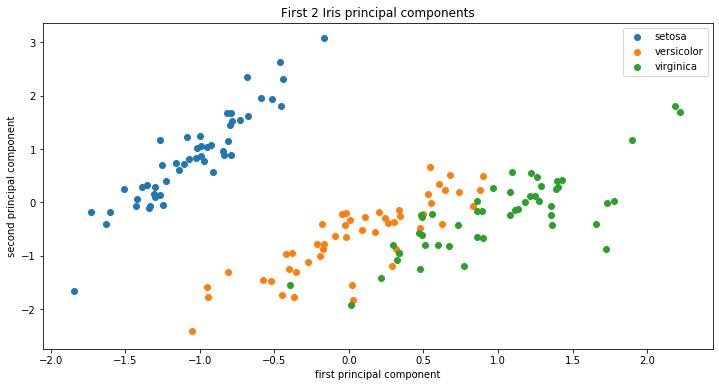

In [8]:
def part4(tfmr, X, y, categories):
    components = tfmr.project(X)
    plt.figure(figsize=(12, 6))
    for i, cat in enumerate(categories):
        plt.scatter(components[y==i, 0], components[y==i, 1], label=cat)
    plt.legend()
    plt.xlabel("first principal component")
    plt.ylabel("second principal component")

#Use only the first 2 components.
my_PCA.n_components = 2
part4(my_PCA, X, iris.target, iris.target_names)
plt.title("First 2 Iris principal components")
plt.show()

This 2-variable PCA seems to do a pretty good job of separating Setosa from the other classes, but Versicolor and Viriginica still have overlap.  As we can see, the blue dots (setosa) are in a distinct group, but the orange and green dots (veriscolor and virginica) are mixed together a bit.  We can see that the separation also primarily happens along the first component, but the second component is also helpful.  Considering our skree plot, this makes sense.

### Breast Cancer part (i)

In [9]:
breast_cancer = load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
#No ids, and most data seems relevant.

### Breast Cancer part (ii)
The features measure entirely different things (like radius and area), and so centering and normalization are necessary.  No data is categorical, so MCA is not necessary.

In [10]:
X -= X.mean(axis=0)
X /= X.std(axis=0, ddof=1)

### Breast Cancer part (iii)

Variance for each principal axis: [7.54395316e+03 3.23268942e+03 1.60059502e+03 1.12500379e+03
 9.36478951e+02 6.85778556e+02 3.83525025e+02 2.70718536e+02
 2.36796253e+02 1.99193883e+02 1.66944115e+02 1.48339658e+02
 1.37091058e+02 8.91815230e+01 5.34686601e+01 4.53620709e+01
 3.37386534e+01 2.98874690e+01 2.81032721e+01 1.76985406e+01
 1.70246037e+01 1.55855806e+01 1.38255959e+01 1.02552440e+01
 8.79336214e+00 4.64489944e+00 3.91946348e+00 9.02743911e-01
 4.25320159e-01 7.55694594e-02]


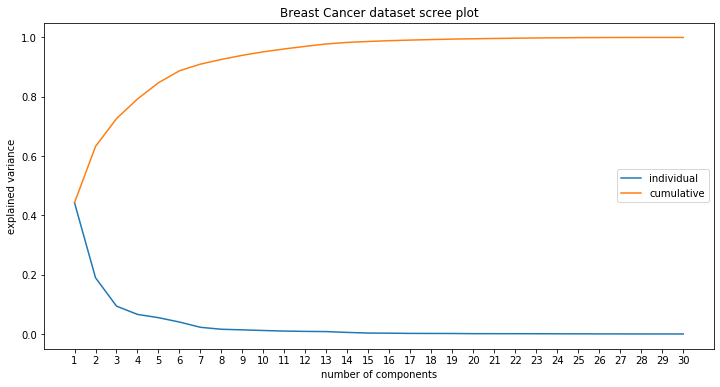

In [11]:
my_PCA = PCATransformer()
part3(my_PCA, X)
plt.title("Breast Cancer dataset scree plot")
plt.show()

It looks like with 3 of the principal components you can explain roughly 75% of the variance, with 8 you can explain nearly 90% and with 15 you can explain nearly all of it.  If I had to choose a number of components to use, I would probably do 3 or 4.

### Breast Cancer part (iv)

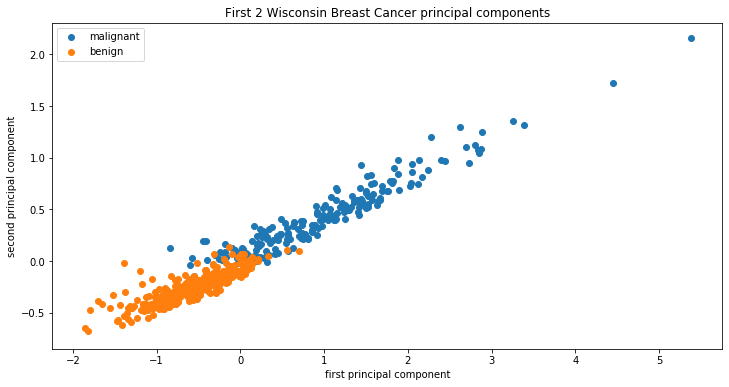

In [12]:
#Use only the first 2 components.
my_PCA.n_components = 2
part4(my_PCA, X, breast_cancer.target, breast_cancer.target_names)
plt.title("First 2 Wisconsin Breast Cancer principal components")
plt.show()

This 2-variable PCA seems to do a pretty good job of separating the different classes.  While they're not linearly separable, the lower left is clearly a spot where 'benign' is more common, and the upper right is where 'malignant' is much more common.

### Fashion-MNIST part (i)

No id numbers, and no irrelevant data.

In [13]:
(train_photo, y_train), (test_photo, y_test) = fashion_mnist.load_data()

### Fashion-MNIST part (ii)

Data is suitable for PCA as is, because it's pixels in an image.  Very comparable.  Just need to mean shift and unravel it from matices to row vectors.

In [14]:
N_samps, height, width = train_photo.shape
photo_mean = train_photo.mean(axis=0)
mean_shifted = train_photo - photo_mean
X = mean_shifted.reshape((N_samps, height*width))

### Fashion-MNIST part (iii)

Variance for first 50 principal axes: [7.72866687e+10 4.72550015e+10 1.60199030e+10 1.31939836e+10
 1.02403704e+10 9.21069019e+09 6.23230962e+09 5.07117725e+09
 3.59255085e+09 3.49786591e+09 2.64249497e+09 2.43058902e+09
 2.03812430e+09 1.75577830e+09 1.61776877e+09 1.56978475e+09
 1.46894960e+09 1.39593397e+09 1.21915755e+09 1.21233305e+09
 1.15423033e+09 1.08347256e+09 1.02401704e+09 9.91529691e+08
 9.61070057e+08 9.33256528e+08 8.86907198e+08 8.49962470e+08
 8.19895837e+08 7.80533257e+08 7.33504887e+08 7.05451053e+08
 7.01835270e+08 6.80894787e+08 6.55283490e+08 6.27841190e+08
 6.12906798e+08 6.00218140e+08 5.81464483e+08 5.57107128e+08
 5.33043100e+08 5.20952767e+08 5.18157407e+08 4.86469656e+08
 4.66697838e+08 4.57574247e+08 4.49231892e+08 4.36412009e+08
 4.28249716e+08 4.12116827e+08]


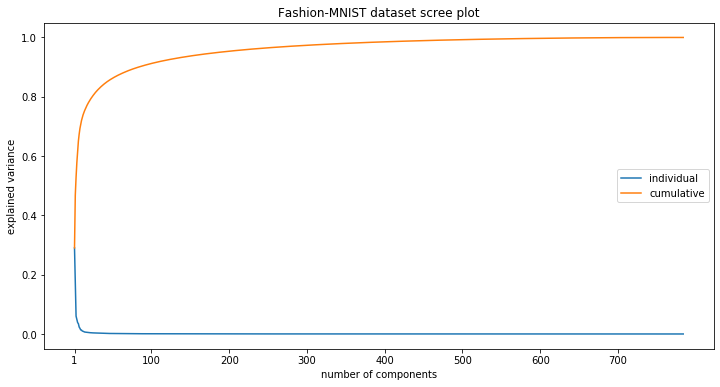

In [15]:
my_PCA = PCATransformer()
part3(my_PCA, X)
plt.title("Fashion-MNIST dataset scree plot")
plt.show()

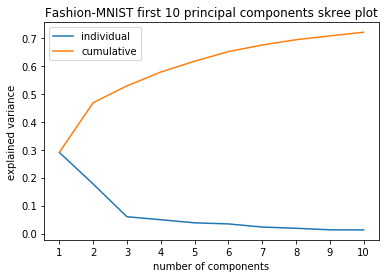

In [16]:
#Zoom in on the first 10 variances.
x = np.arange(1, 11)
tot_var = my_PCA.variances_.sum()
first10 = my_PCA.variances_[:10]
plt.plot(x, first10/tot_var, label='individual')
plt.plot(x, first10.cumsum()/tot_var, label='cumulative')
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.xticks(x)
plt.legend()
plt.title("Fashion-MNIST first 10 principal components skree plot")
plt.show()

The first 3 components explain nearly half the variance, and the first 10 explain nearly 70%.

### Fashion-MNIST part (iv)

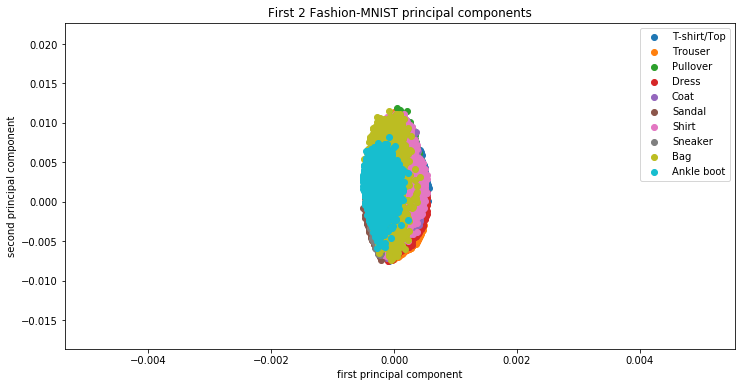

In [17]:
#Use only the first 2 components.
my_PCA.n_components = 2
labels = ['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
part4(my_PCA, X, y_train, labels)
plt.title("First 2 Fashion-MNIST principal components")
plt.show()

This PCA does a terrible job at separating the different classes.  That makes sense, since the fist two components accounted for only half of the variance.

### Fashion-MNIST part (v)
Find the minimum number of principal components necessaryto account for 90% of the variance.

In [18]:
min_needed = np.searchsorted(my_PCA.variances_.cumsum()/tot_var, .90) + 1
print("Need {} principal components to explain 90% of the variance".format(min_needed))

Need 84 principal components to explain 90% of the variance


Orthogonally project the data onto the subspace spanned by those principal axes ($\text{proj}_{\text{span}(\mathbf{v}_1, \ldots, \mathbf{v}_s)}\mathbf{x} = \sum_{i=1}^{s}a_i \mathbf{v}_i$) and plot a random selection of 20 of the resulting images, along with the corresponding 20 images of the original dataset.

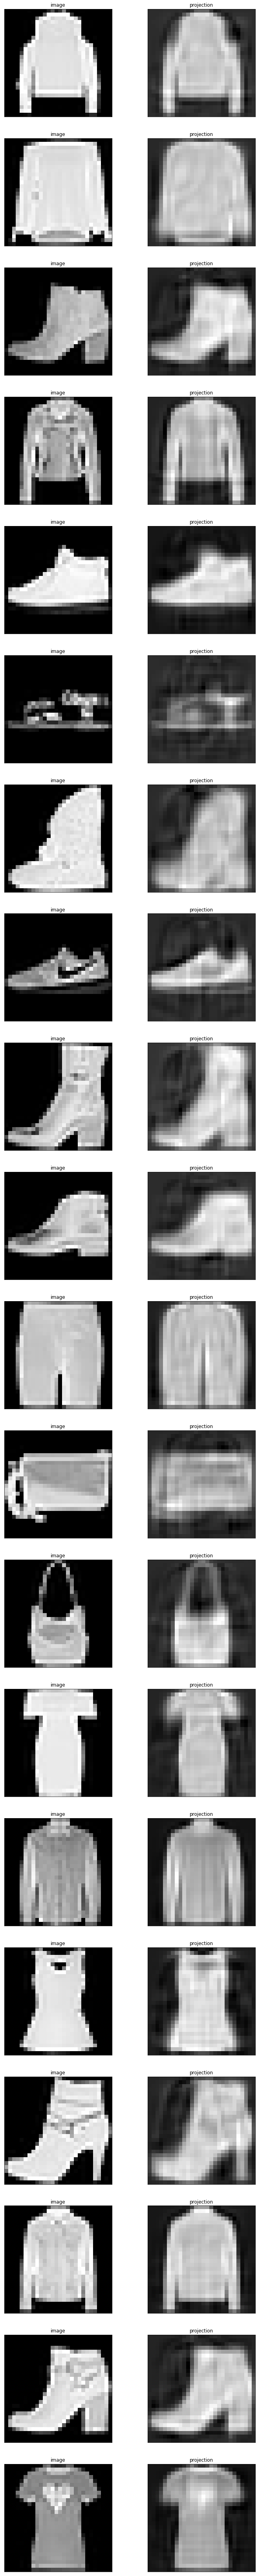

In [19]:
my_PCA.n_components = min_needed
samp_inds = np.random.choice(N_samps, size=20)
rand_samps = X[samp_inds, :]
projections = my_PCA.project(rand_samps)
fig, axes = plt.subplots(nrows=20, ncols=2, figsize=(12, 6*20))
for x, proj_x, axes_row in zip(rand_samps, projections, axes):
    ax1, ax2 = axes_row
    image = x.reshape(height, width) + photo_mean
    proj_image = proj_x.reshape(height, width) + photo_mean
    ax1.imshow(image, cmap='gray')
    ax1.set_title("image")
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.imshow(proj_image, cmap='gray')
    ax2.set_title("projection")
    ax2.set_xticks([])
    ax2.set_yticks([])
plt.show()

## Exercise 10.4
Add Gaussian noise $\sim \mathscr{N}(0, I)$ to each image in the Fashion-MNST dataset, apply PCA, and orthogonally project to the subspace spanned by the fewest principal axes needed to account for 90% of the variance.

In [20]:
#Problem says to use I for covariance, but I'm going to make the noise louder.
louder = (train_photo.max() - train_photo.min())/20
noise = np.random.normal(loc=0, scale=louder, size=train_photo.shape)
noised_photo = train_photo + noise
noise_PCA = PCATransformer()
mean_noised_photo = noised_photo.mean(axis=0)
X = (noised_photo - mean_noised_photo)
X = X.reshape((N_samps, -1))
noise_PCA.fit(X)
variances = noise_PCA.variances_.copy()
min_needed = np.searchsorted(variances.cumsum()/variances.sum(), .90) + 1
print("Need {} principal components to explain 90% of the variance".format(min_needed))
noise_PCA.n_components = min_needed
proj_X = noise_PCA.project(X)
proj_noise_photo = proj_X.reshape(train_photo.shape) + mean_noised_photo

Need 116 principal components to explain 90% of the variance


Plot 20 randomly selected images from the clean, original dataset, the corresponding 20 of the noisy images, and the corresponding 20 of the filtered images.

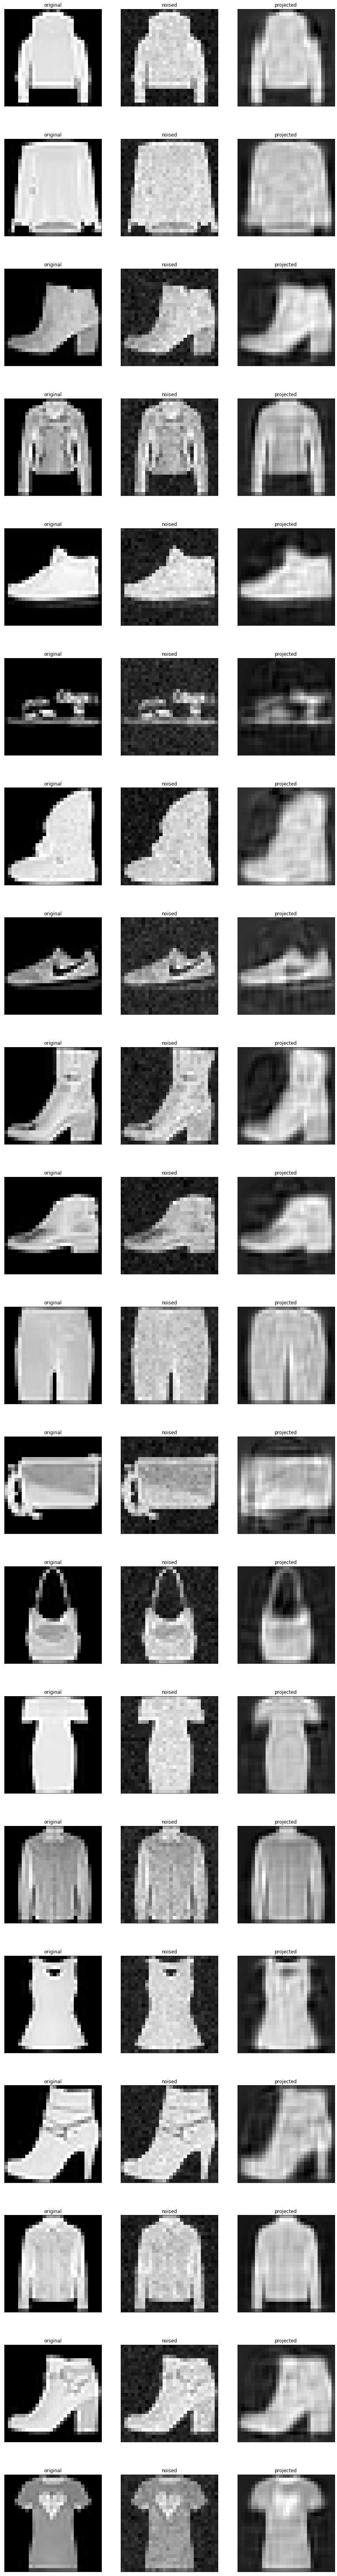

In [21]:
fig, axes = plt.subplots(nrows=20, ncols=3, figsize=(15, 6*20))
for i, axes_row in zip(samp_inds, axes):
    ps = [train_photo[i], noised_photo[i], proj_noise_photo[i]]
    names = ['original', 'noised', 'projected']
    for ax, p, name in zip(axes_row, ps, names):
        ax.imshow(p, cmap='gray')
        ax.set_title(name)
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()

## Exericise 10.5
Code up the MCA method.  Your code should accept a binary data matrix $Y$ (the output of the one-hot encoder) and convert it to a matrix $X$ of continuous data whose entries $x_{ik}$ are as described in Section 10.1.5.

In [22]:
class MCATransformer(TransformerMixin):
    
    def fit(self, Y, y=None):
        self.p_ = Y.mean(axis=0, keepdims=True)
    
    def transform(self, Z):
        return (Z / self.p_) - 1
    
    def fit_transform(self, Y):
        """
        Parameters
        ----------
        Y : ndarray of shape (N, d)
            one-hot encoded input.
            Y[i,:] corresponds to one observation.
        
        Returns
        -------
        X : ndarray of shape (N, d)
            Transformed data, following the algorithm in section 10.1.5.
        """
        self.fit(Y)
        return self.transform(Y)